## Worden: vector encoded words based text generation



In [ ]:
# Run on colab
ON_COLAB = False  
# Define colab directory
COLAB_PATH = '/content/drive/My Drive/UniPD/2019_20_Neural_Network_Deep_Learning/nndl-03'
# Wheter to sample embedding again or not
MAKE_EMBEDDINGS = False
# Hyperparameters grid search
HYPER_TRAIN = False
# Model training
MODEL_TRAIN = False
# Number of training epoch
NUM_EPOCHS = 1000
# Batch size
BATCH_SIZE = 100
# Epochs saving interval
SAVE_AFTER = 100
# Percentage of training examples
TRAIN_PERC = 0.95
# Size of each sentence
CROP_LEN = 10
# Define embedding dimension
EMBEDDING_DIM = 100
# Define path to visualized model
# MODEL_PATH = 'data/worden/2020_09_10_23_30_51'
MODEL_PATH = 'data/worden/2020_09_11_10_49_22'

In [2]:
# Do only if colab setup has been chosen
if ON_COLAB:

    # Install some packages
    !pip install unidecode
    
    # Import google drive dependencies
    from google.colab import drive
    import os
    
    # Mount remote drive
    drive.mount('/content/drive', force_remount=True)
    # Change working directory
    os.chdir(COLAB_PATH)

In [3]:
# Dependencies
from src.network.network import grid_search, save_epochs, load_epochs, train_test_epochs
from src.network.worden import Worden
from src.dataset.transform import WordToVector, RandomCrop, ToTensor
from src.dataset.dataset import train_test_split
from src.dataset.dickens import DickensGE
from src.embeddings import Glove
from src.embeddings import plot_embeddings
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import optim, nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import random
import torch
import json
import os

# Initialize torch random generator
torch.manual_seed(42)
# Initialize numpy random generator
np.random.seed(42)
# Initialize python random seed
random.seed(42)

%matplotlib inline

In [4]:
# Define CPU device
cpu = torch.device('cpu')
# Define best device (GPU if available, CPU otherwise)
device = torch.device('cuda') if torch.cuda.is_available() else cpu

# Show chosen device
device

device(type='cuda')

In [5]:
# Make dataset
dataset = DickensGE.from_file('./data/great-expectations-dickens.txt', split_fn=DickensGE.split_words, min_length=20)
# Show dataset length (number of sentences)
print('Dataset length:', len(dataset))

Dataset length: 2823


In [6]:
# Show first 3 sentences
for i in range(10):
    print(dataset[i])

['my', 'father', "'s", 'family', 'name', 'being', 'pirrip', ',', 'and', 'my', 'christian', 'name', 'philip', ',', 'my', 'infant', 'tongue', 'could', 'make', 'of', 'both', 'names', 'nothing', 'longer', 'or', 'more', 'explicit', 'than', 'pip', '.', 'so', ',', 'i', 'called', 'myself', 'pip', ',', 'and', 'came', 'to', 'be', 'called', 'pip', '.', '\n']
['i', 'give', 'pirrip', 'as', 'my', 'father', "'s", 'family', 'name', ',', 'on', 'the', 'authority', 'of', 'his', 'tombstone', 'and', 'my', 'sister', ',', 'mrs', '.', 'joe', 'gargery', ',', 'who', 'married', 'the', 'blacksmith', '.', 'as', 'i', 'never', 'saw', 'my', 'father', 'or', 'my', 'mother', ',', 'and', 'never', 'saw', 'any', 'likeness', 'of', 'either', 'of', 'them', 'for', 'their', 'days', 'were', 'long', 'before', 'the', 'days', 'of', 'photographs', ',', 'my', 'first', 'fancies', 'regarding', 'what', 'they', 'were', 'like', 'were', 'unreasonably', 'derived', 'from', 'their', 'tombstones', '.', 'the', 'shape', 'of', 'the', 'letters', '

In [7]:
# Initialize set of words in text
words = set()
# Go through each sentence in dataset
for i in range(len(dataset)):
    # Turn sentence (list of words) into set
    sentence = set(dataset[i])
    # Update words set
    words |= sentence
    
# Sort words
words = sorted(words)
# Show some available words
print(words[:15])

['\n', '!', '"', "'", "'ll", "'s", "'t", ',', '.', '?', 'a', "a'most", 'aback', 'abandoned', 'abased']


### Embeddings

In [8]:
# Define embedding dimension
embedding_dim = EMBEDDING_DIM
# Show embedding dimension
print('Embedding dimension is: {:d}'.format(embedding_dim))

Embedding dimension is: 100


In [9]:
# Initialize embeddings
embeddings = dict()
# Define path to embeddings file
embeddings_path = 'data/worden/embeddings.json'

# Case embeddings are available from file
if os.path.isfile(embeddings_path):
    # Read from file
    with open(embeddings_path, 'r') as file:
        # Load embeddings
        embeddings = json.load(file)

In [10]:
# Otherwise, retrieve vectors from Glove or sample them
if MAKE_EMBEDDINGS:
    
    # Load glove embeddings
    glove = Glove.from_file(path='data/glove.6B/glove.6B.100d.txt', words=words)
    # Define sample mean and standard deviation (from plot)
    mean, std = -0.01, 0.47
    
    # Reinitialize embeddings dictionary
    embeddings = dict()
    # Loop through each word (plus unknown vector)
    for word in ['', *words]:
        # Sample vector using normal distribution
        vector = np.random.normal(loc=mean, scale=std, size=(embedding_dim, )).tolist()
        # Eventually, retrieve vector from glove
        vector = glove.get(word, vector)
        # Store vector, associate it to current word
        embeddings.setdefault(word, vector)

    # Save embeddings to dictionary
    with open(embeddings_path, 'w') as file:
        # Store embeddings
        json.dump(embeddings, file)

# Get ordered list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

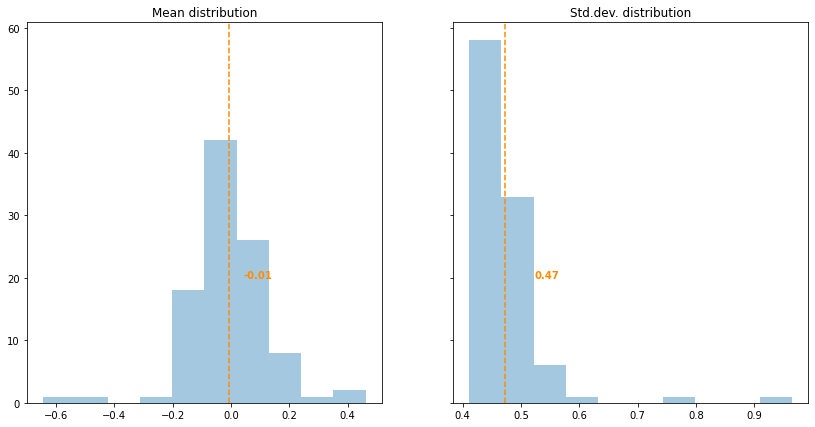

In [11]:
# Plot mean and variance distribution in retrieved embeddings
plot_embeddings(embeddings)

In [12]:
# Show some embeddings

# Initialize output message
msg = ['Embeddings:']
# Add new message
msg += [
    '{:s}\t({:d}):\t[{:s}, ...]'.format(repr(word), i + 1, ', '.join(['%.02f' % v for v in vector[:10]]))
    for i, (word, vector)
    in enumerate([*embeddings.items()][:10])
]
# Add to-be-continued row
msg += ['...']
# Show message
print('\n'.join(msg))

Embeddings:
''	(1):	[0.22, -0.07, 0.29, 0.71, -0.12, -0.12, 0.73, 0.35, -0.23, 0.25, ...]
'\n'	(2):	[-0.68, -0.21, -0.17, -0.39, -0.09, 0.18, 0.88, 0.07, 0.11, -0.04, ...]
'!'	(3):	[0.38, 0.49, 0.49, -1.54, -0.34, 0.62, 0.32, 0.08, 0.66, -0.24, ...]
'"'	(4):	[-0.30, -0.24, 0.18, -0.73, -0.28, -0.26, 0.27, 0.03, -0.07, -0.38, ...]
"'"	(5):	[-0.35, -0.25, 0.59, -0.89, -1.10, -0.45, -0.07, -0.45, -0.38, -0.49, ...]
"'ll"	(6):	[-0.23, 0.52, 0.50, -0.69, -0.53, 0.18, -0.26, 0.59, 0.07, -0.42, ...]
"'s"	(7):	[0.59, -0.20, 0.73, -0.68, -0.20, -0.18, -0.39, 0.34, -0.61, 0.64, ...]
"'t"	(8):	[-0.26, 0.48, -0.34, -0.67, -0.74, 0.27, -0.61, 0.81, -0.99, 0.79, ...]
','	(9):	[-0.11, 0.11, 0.60, -0.54, 0.67, 0.11, 0.04, 0.35, 0.06, -0.09, ...]
'.'	(10):	[-0.34, 0.21, 0.46, -0.65, -0.38, 0.04, 0.17, 0.16, 0.47, -0.02, ...]
...


In [13]:
# Define random crop
random_crop = RandomCrop(CROP_LEN)
# Define word to vector transform
word_to_vector = WordToVector(words)
# Define tensor parser
to_tensor = ToTensor(torch.long)

# Define transformation for dataset
dataset.transform = transforms.Compose([
  random_crop,
  word_to_vector,
  to_tensor
])

In [14]:
# Show first 3 sentences shapes
for i in range(3):
    print('Sentence nr {:d} has shape {:d}'.format(i+1, *dataset[i].shape))
print('...')

Sentence nr 1 has shape 10
Sentence nr 2 has shape 10
Sentence nr 3 has shape 10
...


### Hyperparameters tuning

In [15]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = train_test_split(dataset, TRAIN_PERC)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Do only if hyperparameters training is enabled
if HYPER_TRAIN:
    
    # Make parameters training
    train_losses, train_times, test_losses, test_times, params = grid_search(
        train_dl=train_dataloader, test_dl=test_dataloader,
        net=[Worden], net__vocab_size=[len(words)], net__embedding_dim=[embedding_dim],
        net__trained_embeddings=[vectors], net__freeze_embeddings=[False],
        net__hidden_units=[128, 256], net__layers_num=[2, 3],
        net__hidden_type=['GRU', 'LSTM'], net__dropout_prob=[0.1, 0.3],
        optim=[optim.Adam], lr=[1e-3, 1e-4], optim__weight_decay=[1e-4, 1e-5],
        loss_fn=[nn.CrossEntropyLoss],
        num_epochs=10,
        verbose=True,
        device=device
    )

    # Store parameters to disk
    save_epochs(
        path='data/worden/hyper.json',
        train_losses=train_losses,
        train_times=train_times,
        test_losses=test_losses,
        test_times=test_times,
        params=[{
            # Turn param value into string
            str(kw): str(params[i][kw]) for kw in params[i]}
            # Loop through each parameter combination
            for i in range(len(params))
        ]
    )

In [17]:
# Load parameters from disk
train_losses, train_times, test_losses, test_times, others = load_epochs(
    path='data/worden/hyper.json'
)

# Define common index
index = range(len(train_losses))
# Turn params into a dictionary itself
params = pd.DataFrame.from_records(data=others.get('params'), index=index)
# Make grid search results dataframe
results = pd.DataFrame(index=index, data={
    'train_loss': map(lambda x: x[-1], train_losses),
    'train_time': map(lambda x: x[-1], train_times),
    'test_loss': test_losses,
    'test_time': test_times
})
# Add parameters
results = pd.concat([results, params], axis=1)
# Sort by training loss and training time
results = results.sort_values(by=['test_loss', 'train_time'])
# Show grid search
results.head(3)

,train_loss,train_time,test_loss,test_time,net,net__vocab_size,net__embedding_dim,net__trained_embeddings,net__freeze_embeddings,net__hidden_units,net__layers_num,net__hidden_type,net__dropout_prob,optim,lr,optim__weight_decay,loss_fn
7,5.834407,2.308501,5.550230,0.101115,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
40,6.041143,2.604964,5.588251,0.104593,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,256,2,LSTM,0.1,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
31,6.063674,2.385208,5.638648,0.100980,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,3,LSTM,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>


In [18]:
# Show only the rows where test loss is higher than train one (avoid overfitting)
_results = results[results.test_loss < results.train_loss]
_results = _results[:10]
_results.head(10)

,train_loss,train_time,test_loss,test_time,net,net__vocab_size,net__embedding_dim,net__trained_embeddings,net__freeze_embeddings,net__hidden_units,net__layers_num,net__hidden_type,net__dropout_prob,optim,lr,optim__weight_decay,loss_fn
7,5.834407,2.308501,5.550230,0.101115,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,2,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
40,6.041143,2.604964,5.588251,0.104593,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,256,2,LSTM,0.1,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
31,6.063674,2.385208,5.638648,0.100980,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,3,LSTM,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
60,6.011168,2.736084,5.652858,0.103045,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,256,3,LSTM,0.3,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
43,6.071773,2.613635,5.724272,0.103783,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,256,2,LSTM,0.1,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
15,5.924978,2.315336,5.741113,0.102865,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,2,LSTM,0.3,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
20,6.013884,2.369699,5.769591,0.101619,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
3,5.951995,2.306089,5.777659,0.097589,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,2,GRU,0.1,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
54,6.145443,2.705699,5.792632,0.104316,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,256,3,GRU,0.3,<class 'torch.optim.adam.Adam'>,0.0001,0.0001,<class 'torch.nn.modules.loss.CrossEntropyLoss'>
11,6.011192,2.328246,5.797469,0.101061,<class 'src.network.worden.Worden'>,10680,100,"tensor([[ 0.2235, -0.0750, 0.2944, ..., 0.1...",False,128,2,LSTM,0.1,<class 'torch.optim.adam.Adam'>,0.0001,1e-05,<class 'torch.nn.modules.loss.CrossEntropyLoss'>


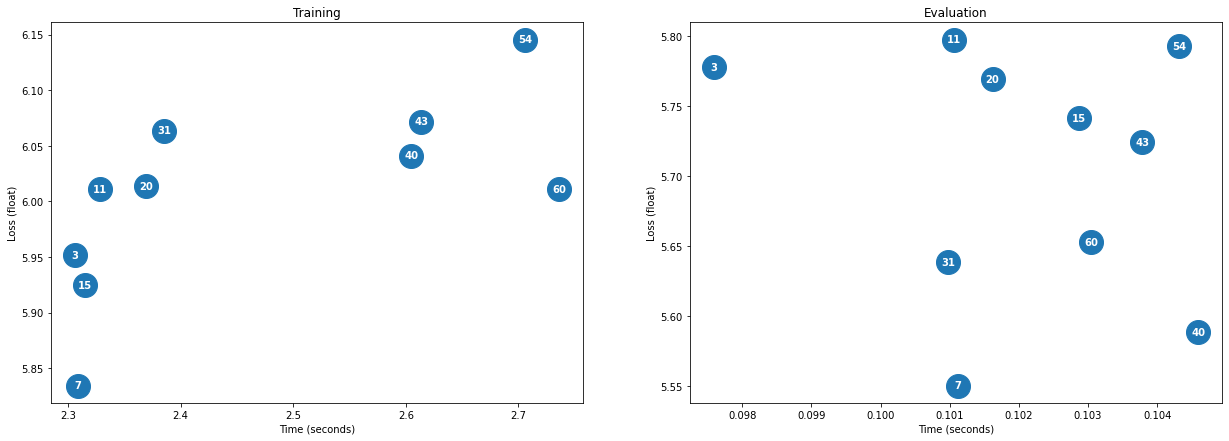

In [19]:
# Plot execution times vs loss

# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(21, 7))

# Retrieve x and y for training
x_train = _results.train_time.tolist()
y_train = _results.train_loss.tolist()
# Retrieve x and y for evaluation
x_eval = _results.test_time.tolist()
y_eval = _results.test_loss.tolist()
# Retrieve indices
indices = _results.index.tolist()

# Make plot
axs[0].plot(x_train, y_train, 'o', markersize=24)
# Loop through every marker in plot
for j, index in enumerate(indices):
    # Add marker index on point
    axs[0].annotate(xy=(x_train[j], y_train[j]), s='%d' % index,
                    color='white', weight='bold', 
                    horizontalalignment='center',
                    verticalalignment='center')
# Set title and labels
axs[0].set_title('Training')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Loss (float)')

# Make plot
axs[1].plot(x_eval, y_eval, 'o', markersize=24)
# Loop through every marker in plot
for j, index in enumerate(indices):
    # Add marker index on point
    axs[1].annotate(xy=(x_eval[j], y_eval[j]), s='%d' % index,
                    color='white', weight='bold', 
                    horizontalalignment='center',
                    verticalalignment='center')
# Set title and labels
axs[1].set_title('Evaluation')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Loss (float)')
# Save plot
plt.savefig('images/worden/hyper.png')
# Show plot
plt.show()

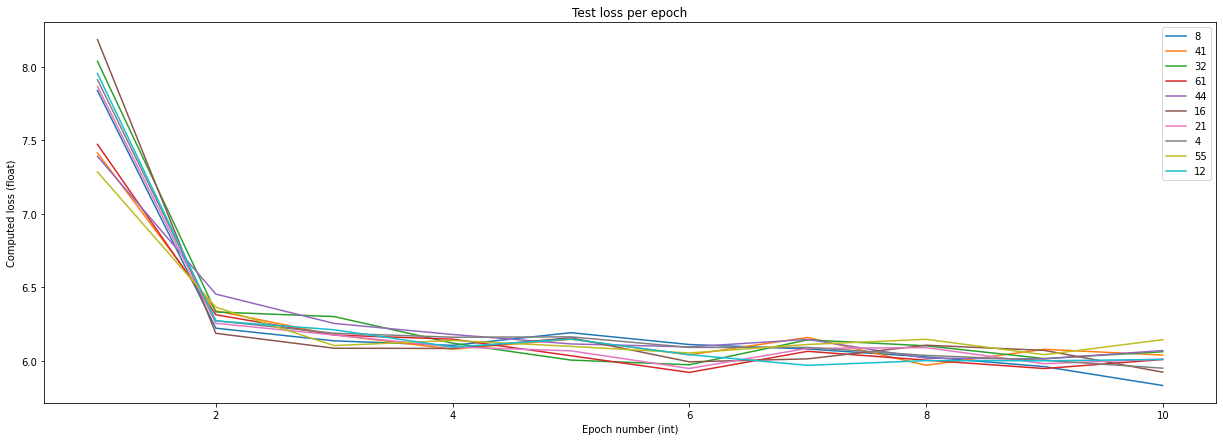

In [20]:
# Plot training loss vs time

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
# Retrieve indices
indices = _results.index.tolist()
# Loop through each train loss in grid search
for i, row in _results.iterrows():
    # Define x (epoch number) and y (loss)
    x = range(1, len(train_losses[i]) + 1)
    y = train_losses[i]
    # Make training scatter
    ax.plot(x, y, '-')
# Set title and labels
ax.set_title('Test loss per epoch')
ax.set_xlabel('Epoch number (int)')
ax.set_ylabel('Computed loss (float)')
# Add legend
ax.legend(['%s' % (i + 1) for i in indices])
# Show plot
plt.show()

### Model training

Best model has following parameters:
* Number of hidden units: 128
* Number of layers: 2
* Dropout probability: 0.3
* Recurrent layer type: GRU
* Adam optimizer
    * Linear rate: 1e-4
    * Weight decay: 1e-5

In [21]:
# Instantiate new network
net = Worden(vocab_size=len(words), embedding_dim=embedding_dim,
             trained_embeddings=vectors, freeze_embeddings=False,
             hidden_units=128, layers_num=2, hidden_type='GRU',
             dropout_prob=0.3)
# Move network to selected device
net.to(device)
# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Show network
net

Worden(
  (rnn): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=128, out_features=10680, bias=True)
  (embed): Embedding(10680, 100)
)

In [22]:
# # Define network path
# net_path = 'data/worden/model.pth'
# # Define epochs path
# epochs_path = 'data/worden/train.json'

# Define encode function
def encode_fn(string):
    # Clean input text
    string = dataset.clean_text(string)
    # Split input string in words
    words = dataset.split_words(string)
    # Turn unknown words into unknown string
    words = [(w if w in word_to_vector.words else '') for w in words]
    # One hot encode characters
    encoded = word_to_vector(words)
    # Cast encoded sentence to tensor
    return to_tensor(encoded).unsqueeze(0)
    

# Define decode function
def decode_fn(index):
    return word_to_vector.decoder.get(index)

In [23]:
# Define number of epochs
num_epochs = NUM_EPOCHS
# Define number of epochs per checkpoint
save_after = SAVE_AFTER

# Do only if model training is enabled
if MODEL_TRAIN:
    
    # Define actual datetime
    now = datetime.datetime.now()
    # Define training path
    train_path = 'data/worden/%s' % now.strftime('%Y_%m_%d_%H_%M_%S')
    # Define network path
    net_path = train_path + '/net.pth'
    # Define epochs path
    epochs_path = train_path + '/epochs.json'
    
    # Make directory
    os.makedirs(train_path, exist_ok=True)
  
    # Define verbose seed
    seed = 'I beg you want to test this'
    # Make train and test
    train_test_epochs(
        net=net, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs,
        train_dl=train_dataloader, test_dl=test_dataloader, 
        seed=seed, crop_len=CROP_LEN, encode_fn=encode_fn, decode_fn=decode_fn,
        save_after=SAVE_AFTER, net_path=net_path, epochs_path=epochs_path,
        verbose=True, device=device
    )

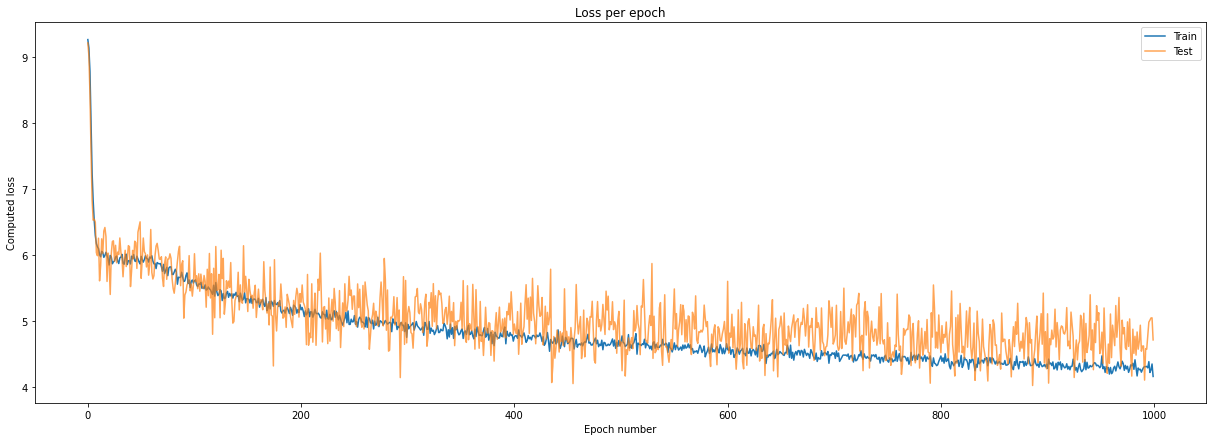

In [24]:
# Show epochs loss

# Load epochs
train_losses, train_times, test_losses, test_times, _ = load_epochs(path=MODEL_PATH + '/epochs.json')
# Define number of epochs
num_epochs = len(train_losses)

# Initialize plot
fig, ax = plt.subplots(figsize=(21, 7))
# Set title and labels
ax.set_title('Loss per epoch')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Computed loss')
# Plot scatter
ax.plot(range(num_epochs), train_losses, '-')
ax.plot(range(num_epochs), test_losses, '-', alpha=.7)
# Add legend
ax.legend(['Train', 'Test'])
# Save plot
plt.savefig('images/worden/epochs.png')
# Show plot
plt.show()

### Text generation

In [25]:
# Load network from file
net, _ = Worden.from_file(path=MODEL_PATH + '/net.pth')
# Set network in evaluation mode
net.eval()

Worden(
  (rnn): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=128, out_features=10680, bias=True)
  (embed): Embedding(10680, 100)
)

In [26]:
# Define input seed sentence
seed = 'Once upon a time there was'
# Generate text using trained network
generated = net.generate_text(
    # Set seed sentence
    seed=seed,
    # Number of characters to predict
    num_words=1000,
    # Set encoding function
    encode_fn=encode_fn,
    # Set decoding function
    decode_fn=decode_fn,
    # Decision function
    decision_how='softmax'
)

# Print seed sentence
print('Generated text (seed: "%s")' % seed)
# Print generated text
print(generated)

Generated text (seed: "Once upon a time there was")
Once upon a time there was a little perspiration, and the last stunned such a holiday about the great sister. it was pleasant and perhaps to take me."

 you, ma'am," except the next wonder, winking at midnight," what was a sister."

."

, that hemmed miss havisham neither?"

 estella."

!

, and stood at the poker with the behind pip. will are it pretences on, sir, and when, rang on whether nor do to put the further of finding to least utterly forgotten.

, turning a loophole," said mr. pumblechook," a saint unoffending or no empty and cherished playful plump."

 night.

 you've a man. and gargery either difficult to go so! you a forced with his pockets, and then ever your sister would have those diamond and moody capital to the rum, as you were offered to bentley the forge for wot't do it conscience together. you think?"

 the old."

 into behind readily, well.

, and on your hat."

 round my own bank over it, love a ghastly biddy, t